In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# 加载特征文件
feature_files = [
    "传统特征250维.xlsx",
    "vgg4096维.xlsx",
    "Clip512维.csv",
    "动态手工6维.csv",
    "c3d487维.csv",
    "timesformer512维.xlsx"
]

# 加载标签文件
label_file = "2187.xlsx"
'''
# 读取特征和标签
features = []
for file in feature_files:
    if file.endswith('.xlsx'):
        features.append(pd.read_excel(file, nrows=100).values)
    elif file.endswith('.csv'):
        features.append(pd.read_csv(file, nrows=100).values)

# 合并所有特征
features = np.concatenate(features, axis=1)

# 读取标签
labels = pd.read_excel(label_file, nrows=100).values


'''
# 读取特征和标签
features = []
for file in feature_files:
    if file.endswith('.xlsx'):
        features.append(pd.read_excel(file).values)
    elif file.endswith('.csv'):
        features.append(pd.read_csv(file).values)

# 合并所有特征
features = np.concatenate(features, axis=1)

# 读取标签
labels = pd.read_excel(label_file).values
# 数据归一化
scaler = MinMaxScaler()
features = scaler.fit_transform(features)
labels = scaler.fit_transform(labels)  # 归一化标签

# 数据集划分
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)# 替换 NaN 为 0
X_train = np.nan_to_num(X_train, nan=0.0)
X_test = np.nan_to_num(X_test, nan=0.0)

In [6]:
import torch
import torch.nn as nn

class MultiTaskTransformerModel(nn.Module):
    def __init__(self, input_dim, shared_dim, task_dims, num_tasks, num_heads=4):
        super(MultiTaskTransformerModel, self).__init__()
        self.num_tasks = num_tasks

        # 共享特征提取层（更深的 MLP 结构）
        self.shared_layers = nn.Sequential(
            nn.Linear(input_dim, 1024),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, shared_dim),
            nn.ReLU()
        )

        # **多头注意力（任务交互）**
        self.multihead_attention = nn.MultiheadAttention(embed_dim=shared_dim, num_heads=num_heads, batch_first=True)

        # 任务特定网络（带 `LayerNorm`，防止梯度爆炸）
        self.task_networks = nn.ModuleList([
            nn.Sequential(
                nn.Linear(shared_dim, task_dim),
                nn.LayerNorm(task_dim),  # 加入 `LayerNorm`
                nn.ReLU(),
                nn.Linear(task_dim, task_dim),
                nn.ReLU(),
                nn.Linear(task_dim, task_dim // 2),
                nn.ReLU()
            ) for task_dim in task_dims
        ])

        # 任务输出层
        self.task_output_layers = nn.ModuleList([
            nn.Linear(task_dim // 2, 1) for task_dim in task_dims
        ])

    def forward(self, x):
        # **共享特征提取**
        shared_features = self.shared_layers(x)  # (batch_size, shared_dim)

        # **多头注意力交互**
        attn_output, _ = self.multihead_attention(shared_features.unsqueeze(1), shared_features.unsqueeze(1), shared_features.unsqueeze(1))
        attn_output = attn_output.squeeze(1)  # 还原 batch 维度

        # 任务特定输出
        task_outputs = []
        for i in range(self.num_tasks):
            task_specific_features = self.task_networks[i](attn_output)
            task_output = self.task_output_layers[i](task_specific_features)
            task_outputs.append(task_output)

        return torch.cat(task_outputs, dim=1)







#记录 MAE、MSE、R² 每个 Epoch
def train_model(model, X_train, y_train, X_test, y_test, epochs=50):
    optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10)
    train_losses, test_losses = [], []

    metrics_history = {"mae": [[] for _ in range(num_tasks)],
                       "mse": [[] for _ in range(num_tasks)],
                       "r2": [[] for _ in range(num_tasks)]}

    for epoch in range(epochs):
        model.train()
        inputs = torch.tensor(X_train, dtype=torch.float32)
        targets = torch.tensor(y_train, dtype=torch.float32)

        # 前向传播
        outputs = model(inputs)
        loss = nn.MSELoss()(outputs, targets)

        # 反向传播
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # 评估
        model.eval()
        with torch.no_grad():
            test_inputs = torch.tensor(X_test, dtype=torch.float32)
            test_targets = torch.tensor(y_test, dtype=torch.float32)
            test_outputs = model(test_inputs)

            test_loss = nn.MSELoss()(test_outputs, test_targets)

            # 计算每个任务的 MAE, MSE, R²
            for i in range(num_tasks):
                mae = mean_absolute_error(test_targets[:, i], test_outputs[:, i])
                mse = mean_squared_error(test_targets[:, i], test_outputs[:, i])
                r2 = r2_score(test_targets[:, i], test_outputs[:, i])

                metrics_history["mae"][i].append(mae)
                metrics_history["mse"][i].append(mse)
                metrics_history["r2"][i].append(r2)

        train_losses.append(loss.item())
        test_losses.append(test_loss.item())

        # 学习率调度器
        scheduler.step(test_loss)

        print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {loss.item():.4f}, Test Loss: {test_loss.item():.4f}")

    return train_losses, test_losses, metrics_history


def evaluate_model(model, X_test, y_test):
    model.eval()
    with torch.no_grad():
        predictions = model(torch.tensor(X_test, dtype=torch.float32)).detach().numpy()

    final_mae, final_mse, final_r2 = [], [], []

    for i in range(num_tasks):
        mae = mean_absolute_error(y_test[:, i], predictions[:, i])
        mse = mean_squared_error(y_test[:, i], predictions[:, i])
        r2 = r2_score(y_test[:, i], predictions[:, i])

        final_mae.append(mae)
        final_mse.append(mse)
        final_r2.append(r2)

        print(f"Task {i + 1} - MAE: {mae:.4f}, MSE: {mse:.4f}, R²: {r2:.4f}")

    return final_mae, final_mse, final_r2


# 参数设置
# 参数设置
input_dim = features.shape[1]
shared_dim = 32
task_dims = [128, 256, 128, 64, 256]  # 每个任务的特定网络维度
num_tasks = 5
num_heads = 2

# 初始化改进模型
model = MultiTaskTransformerModel(input_dim, shared_dim, task_dims, num_tasks, num_heads)

# 训练模型
train_losses, test_losses, metrics_history = train_model(model, X_train, y_train, X_test, y_test, epochs=50)

# 评估模型
final_mae, final_mse, final_r2 = evaluate_model(model, X_test, y_test)


Epoch 1/50, Train Loss: 0.4382, Test Loss: 0.2938
Epoch 2/50, Train Loss: 0.3152, Test Loss: 0.1759
Epoch 3/50, Train Loss: 0.1919, Test Loss: 0.1085
Epoch 4/50, Train Loss: 0.1191, Test Loss: 0.0915
Epoch 5/50, Train Loss: 0.0977, Test Loss: 0.0711
Epoch 6/50, Train Loss: 0.0748, Test Loss: 0.0461
Epoch 7/50, Train Loss: 0.0483, Test Loss: 0.0324
Epoch 8/50, Train Loss: 0.0337, Test Loss: 0.0336
Epoch 9/50, Train Loss: 0.0340, Test Loss: 0.0383
Epoch 10/50, Train Loss: 0.0377, Test Loss: 0.0386
Epoch 11/50, Train Loss: 0.0369, Test Loss: 0.0353
Epoch 12/50, Train Loss: 0.0330, Test Loss: 0.0333
Epoch 13/50, Train Loss: 0.0304, Test Loss: 0.0343
Epoch 14/50, Train Loss: 0.0314, Test Loss: 0.0354
Epoch 15/50, Train Loss: 0.0330, Test Loss: 0.0344
Epoch 16/50, Train Loss: 0.0328, Test Loss: 0.0319
Epoch 17/50, Train Loss: 0.0310, Test Loss: 0.0296
Epoch 18/50, Train Loss: 0.0292, Test Loss: 0.0285
Epoch 19/50, Train Loss: 0.0283, Test Loss: 0.0284
Epoch 20/50, Train Loss: 0.0280, Test Lo

Epoch 1/50, Train Loss: 0.3662, Test Loss: 0.2281
Epoch 2/50, Train Loss: 0.2521, Test Loss: 0.1009
Epoch 3/50, Train Loss: 0.0894, Test Loss: 0.0576
Epoch 4/50, Train Loss: 0.0403, Test Loss: 0.0476
Epoch 5/50, Train Loss: 0.0452, Test Loss: 0.0319
Epoch 6/50, Train Loss: 0.0303, Test Loss: 0.0796
Epoch 7/50, Train Loss: 0.0485, Test Loss: 0.0363
Epoch 8/50, Train Loss: 0.0458, Test Loss: 0.0333
Epoch 9/50, Train Loss: 0.0299, Test Loss: 0.0735
Epoch 10/50, Train Loss: 0.0420, Test Loss: 0.0371
Epoch 11/50, Train Loss: 0.0299, Test Loss: 0.0286
Epoch 12/50, Train Loss: 0.0349, Test Loss: 0.0324
Epoch 13/50, Train Loss: 0.0296, Test Loss: 0.0566
Epoch 14/50, Train Loss: 0.0331, Test Loss: 0.0455
Epoch 15/50, Train Loss: 0.0291, Test Loss: 0.0314
Epoch 16/50, Train Loss: 0.0295, Test Loss: 0.0306
Epoch 17/50, Train Loss: 0.0307, Test Loss: 0.0381
Epoch 18/50, Train Loss: 0.0282, Test Loss: 0.0496
Epoch 19/50, Train Loss: 0.0298, Test Loss: 0.0403
Epoch 20/50, Train Loss: 0.0280, Test Lo

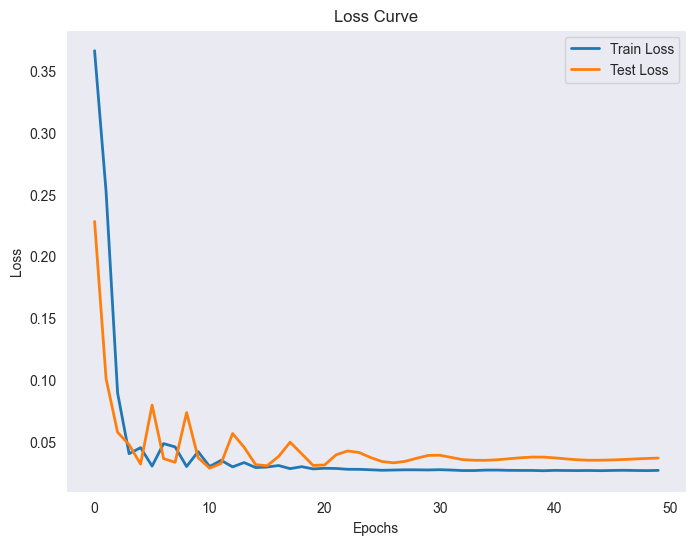

C:\Users\LongLearn\AppData\Local\Temp\ipykernel_22420\69597267.py:163: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=tasks, y=mae, ax=axs[0], palette="Blues")
C:\Users\LongLearn\AppData\Local\Temp\ipykernel_22420\69597267.py:167: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=tasks, y=mse, ax=axs[1], palette="Oranges")
C:\Users\LongLearn\AppData\Local\Temp\ipykernel_22420\69597267.py:171: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=tasks, y=r2, ax=axs[2], palette="Greens")


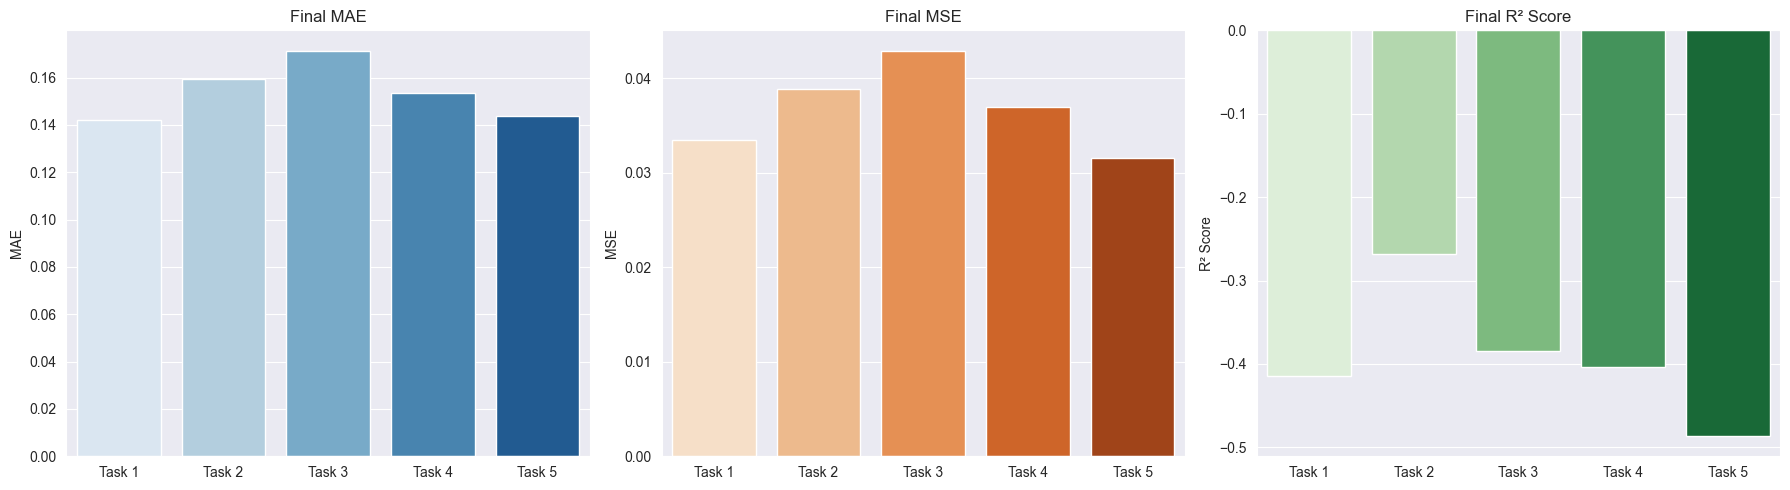

In [3]:

import torch
import torch.nn as nn
import torch.optim as optim


class MultiTaskImprovedModel(nn.Module):
    def __init__(self, input_dim, shared_dim, task_dims, num_tasks):
        super(MultiTaskImprovedModel, self).__init__()
        self.num_tasks = num_tasks

        # 更深的共享特征提取层
        self.shared_layers = nn.Sequential(
            nn.Linear(input_dim, 1024),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, shared_dim),
            nn.ReLU()
        )

        # 每个任务的注意力机制
        self.attention_layers = nn.ModuleList([
            nn.Sequential(
                nn.Linear(shared_dim, shared_dim),
                nn.Tanh(),
                nn.Linear(shared_dim, 1),
                nn.Softmax(dim=1)
            ) for _ in range(num_tasks)
        ])

        # 每个任务的特定网络（更深层次）
        self.task_networks = nn.ModuleList([
            nn.Sequential(
                nn.Linear(shared_dim, task_dim),
                nn.ReLU(),
                nn.Linear(task_dim, task_dim),
                nn.ReLU(),
                nn.Linear(task_dim, task_dim // 2),
                nn.ReLU()
            ) for task_dim in task_dims
        ])

        # 每个任务的最终回归层
        self.task_output_layers = nn.ModuleList([
            nn.Linear(task_dim // 2, 1) for task_dim in task_dims
        ])

    def forward(self, x):
        # 共享特征提取
        shared_features = self.shared_layers(x)

        # 任务特定输出
        task_outputs = []
        for i in range(self.num_tasks):
            # 注意力机制
            attention_weights = self.attention_layers[i](shared_features)
            attended_features = shared_features * attention_weights

            # 任务特定网络
            task_specific_features = self.task_networks[i](attended_features)

            # 任务输出
            task_output = self.task_output_layers[i](task_specific_features)
            task_outputs.append(task_output)

        return torch.cat(task_outputs, dim=1)


from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns

# 训练损失曲线
def plot_losses(train_losses, test_losses, save_path="loss_curve.png"):
    plt.figure(figsize=(8, 6))
    plt.plot(train_losses, label="Train Loss", linewidth=2)
    plt.plot(test_losses, label="Test Loss", linewidth=2)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Loss Curve")
    plt.legend()
    plt.grid()
    plt.savefig(save_path, dpi=300, bbox_inches="tight")  # 保存图片
    plt.show()

# 每个任务的 MAE、MSE、R² 曲线
def plot_metrics_per_epoch(metrics_history, save_path="metrics_per_epoch.png"):
    epochs = len(metrics_history["mae"][0])
    fig, axs = plt.subplots(3, 1, figsize=(8, 15))

    for i in range(len(metrics_history["mae"])):
        axs[0].plot(range(epochs), metrics_history["mae"][i], label=f"Task {i + 1}", linewidth=2)
        axs[1].plot(range(epochs), metrics_history["mse"][i], label=f"Task {i + 1}", linewidth=2)
        axs[2].plot(range(epochs), metrics_history["r2"][i], label=f"Task {i + 1}", linewidth=2)

    axs[0].set_title("Mean Absolute Error (MAE) per Task")
    axs[1].set_title("Mean Squared Error (MSE) per Task")
    axs[2].set_title("R² Score per Task")

    for ax in axs:
        ax.set_xlabel("Epochs")
        ax.legend()
        ax.grid()

    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches="tight")  # 保存图片
    plt.show()

#  MAE、MSE、R² 柱状图
def plot_final_metrics(mae, mse, r2, save_path="final_metrics.png"):
    tasks = [f"Task {i + 1}" for i in range(len(mae))]

    fig, axs = plt.subplots(1, 3, figsize=(18, 5))

    sns.barplot(x=tasks, y=mae, ax=axs[0], palette="Blues")
    axs[0].set_title("Final MAE")
    axs[0].set_ylabel("MAE")

    sns.barplot(x=tasks, y=mse, ax=axs[1], palette="Oranges")
    axs[1].set_title("Final MSE")
    axs[1].set_ylabel("MSE")

    sns.barplot(x=tasks, y=r2, ax=axs[2], palette="Greens")
    axs[2].set_title("Final R² Score")
    axs[2].set_ylabel("R² Score")

    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches="tight")  # 保存图片
    plt.show()




#记录 MAE、MSE、R² 每个 Epoch
def train_model(model, X_train, y_train, X_test, y_test, epochs=50):
    optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10)
    train_losses, test_losses = [], []

    metrics_history = {"mae": [[] for _ in range(num_tasks)],
                       "mse": [[] for _ in range(num_tasks)],
                       "r2": [[] for _ in range(num_tasks)]}

    for epoch in range(epochs):
        model.train()
        inputs = torch.tensor(X_train, dtype=torch.float32)
        targets = torch.tensor(y_train, dtype=torch.float32)

        # 前向传播
        outputs = model(inputs)
        loss = nn.MSELoss()(outputs, targets)

        # 反向传播
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # 评估
        model.eval()
        with torch.no_grad():
            test_inputs = torch.tensor(X_test, dtype=torch.float32)
            test_targets = torch.tensor(y_test, dtype=torch.float32)
            test_outputs = model(test_inputs)

            test_loss = nn.MSELoss()(test_outputs, test_targets)

            # 计算每个任务的 MAE, MSE, R²
            for i in range(num_tasks):
                mae = mean_absolute_error(test_targets[:, i], test_outputs[:, i])
                mse = mean_squared_error(test_targets[:, i], test_outputs[:, i])
                r2 = r2_score(test_targets[:, i], test_outputs[:, i])

                metrics_history["mae"][i].append(mae)
                metrics_history["mse"][i].append(mse)
                metrics_history["r2"][i].append(r2)

        train_losses.append(loss.item())
        test_losses.append(test_loss.item())

        # 学习率调度器
        scheduler.step(test_loss)

        print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {loss.item():.4f}, Test Loss: {test_loss.item():.4f}")

    return train_losses, test_losses, metrics_history


def evaluate_model(model, X_test, y_test):
    model.eval()
    with torch.no_grad():
        predictions = model(torch.tensor(X_test, dtype=torch.float32)).detach().numpy()

    final_mae, final_mse, final_r2 = [], [], []

    for i in range(num_tasks):
        mae = mean_absolute_error(y_test[:, i], predictions[:, i])
        mse = mean_squared_error(y_test[:, i], predictions[:, i])
        r2 = r2_score(y_test[:, i], predictions[:, i])

        final_mae.append(mae)
        final_mse.append(mse)
        final_r2.append(r2)

        print(f"Task {i + 1} - MAE: {mae:.4f}, MSE: {mse:.4f}, R²: {r2:.4f}")

    return final_mae, final_mse, final_r2


# 参数设置
input_dim = features.shape[1]
shared_dim = 512
task_dims = [64, 128, 64, 128, 64]  # 每个任务的特定网络维度
num_tasks = 5

model = MultiTaskImprovedModel(input_dim, shared_dim, task_dims, num_tasks)

# 训练模型
train_losses, test_losses, metrics_history = train_model(model, X_train, y_train, X_test, y_test, epochs=50)

# 绘制损失曲线
plot_losses(train_losses, test_losses)

# 绘制每个任务的 MAE、MSE、R² 变化曲线
plot_metrics_per_epoch(metrics_history)

# 评估模型
final_mae, final_mse, final_r2 = evaluate_model(model, X_test, y_test)

# 绘制最终 MAE、MSE、R² 柱状图
plot_final_metrics(final_mae, final_mse, final_r2)



In [8]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns

# 训练损失曲线
def plot_losses(train_losses, test_losses, save_path="loss_curve.png"):
    plt.figure(figsize=(8, 6))
    plt.plot(train_losses, label="Train Loss", linewidth=2)
    plt.plot(test_losses, label="Test Loss", linewidth=2)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Loss Curve")
    plt.legend()
    plt.grid()
    plt.savefig(save_path, dpi=300, bbox_inches="tight")  # 保存图片
    plt.show()

# 每个任务的 MAE、MSE、R² 曲线
def plot_metrics_per_epoch(metrics_history, save_path="metrics_per_epoch.png"):
    epochs = len(metrics_history["mae"][0])
    fig, axs = plt.subplots(3, 1, figsize=(8, 15))

    for i in range(len(metrics_history["mae"])):
        axs[0].plot(range(epochs), metrics_history["mae"][i], label=f"Task {i + 1}", linewidth=2)
        axs[1].plot(range(epochs), metrics_history["mse"][i], label=f"Task {i + 1}", linewidth=2)
        axs[2].plot(range(epochs), metrics_history["r2"][i], label=f"Task {i + 1}", linewidth=2)

    axs[0].set_title("Mean Absolute Error (MAE) per Task")
    axs[1].set_title("Mean Squared Error (MSE) per Task")
    axs[2].set_title("R² Score per Task")

    for ax in axs:
        ax.set_xlabel("Epochs")
        ax.legend()
        ax.grid()

    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches="tight")  # 保存图片
    plt.show()

#  MAE、MSE、R² 柱状图
def plot_final_metrics(mae, mse, r2, save_path="final_metrics.png"):
    tasks = [f"Task {i + 1}" for i in range(len(mae))]

    fig, axs = plt.subplots(1, 3, figsize=(18, 5))

    sns.barplot(x=tasks, y=mae, ax=axs[0], palette="Blues")
    axs[0].set_title("Final MAE")
    axs[0].set_ylabel("MAE")

    sns.barplot(x=tasks, y=mse, ax=axs[1], palette="Oranges")
    axs[1].set_title("Final MSE")
    axs[1].set_ylabel("MSE")

    sns.barplot(x=tasks, y=r2, ax=axs[2], palette="Greens")
    axs[2].set_title("Final R² Score")
    axs[2].set_ylabel("R² Score")

    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches="tight")  # 保存图片
    plt.show()
# 绘制损失曲线
plot_losses(train_losses, test_losses)

# 绘制每个任务的 MAE、MSE、R² 变化曲线
plot_metrics_per_epoch(metrics_history)



# 绘制最终 MAE、MSE、R² 柱状图
plot_final_metrics(final_mae, final_mse, final_r2)

Epoch 1/100, Train Loss: 1.8353205919265747, Test Loss: 1.302962303161621
Epoch 2/100, Train Loss: 1.20730459690094, Test Loss: 0.8743248581886292
Epoch 3/100, Train Loss: 0.7877309322357178, Test Loss: 0.6337619423866272
Epoch 4/100, Train Loss: 0.6650182604789734, Test Loss: 0.7022965550422668
Epoch 5/100, Train Loss: 0.5630720853805542, Test Loss: 0.8567395210266113
Epoch 6/100, Train Loss: 0.37372204661369324, Test Loss: 0.9018535614013672
Epoch 7/100, Train Loss: 0.24792177975177765, Test Loss: 0.8208096027374268
Epoch 8/100, Train Loss: 0.19337713718414307, Test Loss: 0.7101696133613586
Epoch 9/100, Train Loss: 0.20500458776950836, Test Loss: 0.8626051545143127
Epoch 10/100, Train Loss: 0.23247197270393372, Test Loss: 1.305374264717102
Epoch 11/100, Train Loss: 0.239095538854599, Test Loss: 1.9689022302627563
Epoch 12/100, Train Loss: 0.22154022753238678, Test Loss: 2.718282461166382
Epoch 13/100, Train Loss: 0.18905305862426758, Test Loss: 3.4043500423431396
Epoch 14/100, Train 